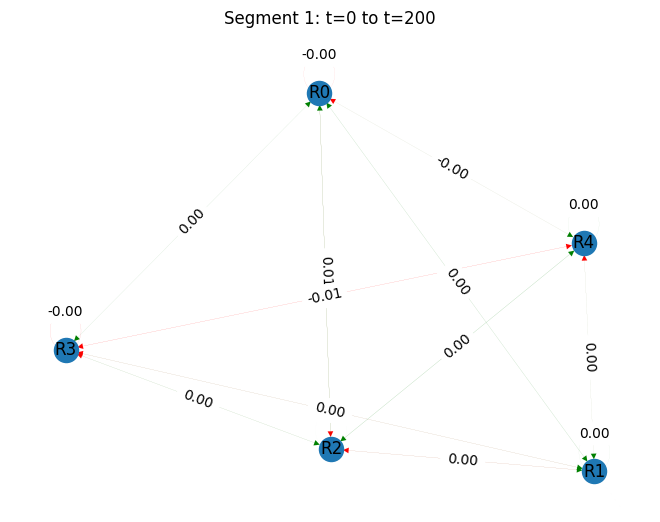

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

region_labels = [f"R{i}" for i in range(5)]

graphs = []

for i, segment in enumerate(segments):
    W_avg = np.mean(segment, axis=2)  # shape (5, 5)
    G = nx.DiGraph()
    G.add_nodes_from(region_labels)

    for src in range(5):
        for tgt in range(5):
            weight = W_avg[src, tgt]
            #if abs(weight) > 0.01:  # skip small/noisy connections
            G.add_edge(region_labels[src], region_labels[tgt], weight=weight)

    graphs.append(G)

    # Optional: visualize each graph
    plt.figure()
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    colors = ['green' if w > 0 else 'red' for w in weights]
    nx.draw(G, pos, with_labels=True, edge_color=colors, width=[abs(w)*10 for w in weights])
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges})
    plt.title(f"Segment {i+1}: t={change_points[i]} to t={change_points[i+1]}")
    plt.show()


In [65]:
print(W_avg)


[[-0.00308685  0.00161885 -0.00220104  0.0002517   0.00234185]
 [ 0.00382791  0.00168219 -0.00365528 -0.00259768 -0.00071462]
 [ 0.00672559  0.0021961   0.0005239  -0.00041185  0.0067337 ]
 [ 0.00290482  0.00293058  0.00479518 -0.00473087 -0.00143591]
 [-0.00074245  0.00242378  0.00029254 -0.00533501  0.00198709]]


In [2]:

# Initialize dataset
brain_dataset = BrainDataset(data_dir=DATA_DIR)
dataset = brain_dataset.get_dataset()

first_trial = next(iter(dataset))
num_regions = first_trial[0].shape[1]
num_source_regions = first_trial[2].shape[1]
num_timepoints_f = first_trial[0].shape[0]
num_timepoints_e = first_trial[1].shape[0]

print(num_regions, num_timepoints_f, num_timepoints_e)

model = MCAN(
    num_regions=num_regions,
    num_timepoints_f=num_timepoints_f,
    num_timepoints_e=num_timepoints_e,
)

outputs = model(first_trial, training=True)

2025-04-29 02:22:53.132 | INFO     | multimodal_causal_adversarial_network.dataset:__init__:131 - Found 7198 valid trials across 40 runs
Skipped 0 invalid trials
6 11 11


/Users/pcoffey/.pyenv/versions/3.12.9/envs/multimodal-causal-adversarial-network/lib/python3.12/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'attention_fusion', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/pcoffey/.pyenv/versions/3.12.9/envs/multimodal-causal-adversarial-network/lib/python3.12/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'mcan', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


: 

In [3]:
outputs["s_f"].shape

TensorShape([11, 11010])

In [ ]:
outputs = model(next(iter(dataset)), training=True)
tf.shape(outputs["s_f"])

In [ ]:
from tensorflow.keras import layers

mha = layers.MultiHeadAttention(num_heads=6, key_dim=64)
layernorm = layers.LayerNormalization()

s_f = outputs["s_f"]
s_e = outputs["s_e"]

# fused_s_f, fused_s_e = model.fusion(outputs["s_f"], outputs["s_e"])
s_mm = tf.concat([s_f, s_e], axis=-1)  # Shape: (11, 34 + 6) = (11, 40)
        
# Transpose to swap the temporal and spatial dimensions (to apply attention over spatial)
s_mm_transposed = tf.expand_dims(tf.transpose(s_mm, perm=[1, 0]), axis=0)  # Shape becomes (1, 12, 11)
s_f_transposed = tf.expand_dims(tf.transpose(s_f, perm=[1,0]), axis=0) # Shape becomes (1, 6, 11)
s_e_transposed = tf.expand_dims(tf.transpose(s_e, perm=[1,0]), axis=0) # Shape becomes (1, 6, 11)

# # Cross-attention between the concatenated Q and individual K (ERP and fMRI)
# # A_erp (attention map for ERP) and A_fmri (attention map for fMRI)
A_erp = mha(query=s_mm_transposed, value=s_e_transposed)  # Apply attention for ERP data
A_fmri = mha(query=s_mm_transposed, value=s_f_transposed)  # Apply attention for fMRI data

print(A_erp.shape)

In [ ]:
from tensorflow.keras import layers

mm = tf.concat([outputs["s_f"], outputs["s_e"]], axis=1)
mm = tf.expand_dims(mm, axis=0)  # Add batch dimension -> Shape: (1, 12, 6)
mha = layers.MultiHeadAttention(num_heads=8, key_dim=64)
att = mha(mm, mm)
att.shape

In [ ]:
precision = CA/TA = 0.5

recall = CA/cardinality(G_expected) = 0.8

SHD = EA + MA + RA = 5